In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat 

In [2]:
B = 512;C = 10000;W = 1.4 * pow(10,6)
f_I = pow(10,9);f_M = pow(10,12)
N_0 = pow(10,-16);P = 0.5 

def arrival_and_departure_times(param1,param2,N):
    a = []
    d = []
    s = 0
    for i in range(N):
        s = s + np.random.exponential(param1)
        a.append(s)
    for i in range(N):
        d.append(a[i] + np.random.exponential(param2))
    return (np.array(a),np.array(d))

def local_cost():
    return ((B*C)/f_I)

def cloud_cost(n):
    h_g_2 = np.random.exponential(0.19)
    R = W * np.log2(1 + P*h_g_2/N_0)
    #R = np.random.choice([R,R/5],p = [0.5,0.5])
    return (B/R + B*C*n/f_M)

def next_state(local_pos,cloud_pos,action):
    if action == 0:
        (new_local_pos,new_cloud_pos,reward) = (local_pos + 1,cloud_pos,-local_cost())
    else:
        (new_local_pos,new_cloud_pos,reward) = (local_pos,cloud_pos + 1,-cloud_cost(cloud_pos))
    return  (new_local_pos,new_cloud_pos,reward)


In [3]:
def Server_Q_learning(N,n,mu,lamda,gamma):
    n = 50
    reward_list = []
    reward_sum_list = []
    reward_sum_avg_list = np.array([0]*N)
    runs = 1
    for ind in range(runs):
        count = 0
        Qa = np.zeros((n,n,2))
        freq = np.ones((n,n))
        freq_action = np.ones((n,n,2))
        (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
        local_pos = 0;cloud_pos = 0
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        reward_sum_list = []
        reward_sum = 0
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
            count = count + 1
            alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
            Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*np.max(Qa[new_local_pos,new_cloud_pos]) - Qa[local_pos,cloud_pos,action])
            freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
            freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1     
            reward_list.append(reward)
            reward_sum = reward_sum + reward
            reward_sum_list.append(reward_sum/count)
        reward_sum_avg_list = reward_sum_avg_list + np.array(reward_sum_list)
    return reward_list,np.array(reward_sum_list),reward_sum_avg_list/runs,local_actions

In [4]:

def Server_DoubleQ_learning(N,n,mu,lamda,gamma):
    n = 50
    reward_list = []
    reward_sum_list = []
    reward_sum_avg_list = np.array([0]*N)
    runs = 1
    
    for ind in range(runs):
        reward_sum = 0
        count = 0
        Qa = np.zeros((n,n,2))
        Qb = np.zeros((n,n,2))
        freq = np.ones((n,n))
        freq_action = np.ones((n,n,2))
        (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
        local_pos = 0;cloud_pos = 0
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        reward_list = []
        reward_sum_list = []
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos] + Qb[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
            count = count + 1
            alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
            if np.random.choice([True,False]):
                Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qb[local_pos,cloud_pos,np.argmax(Qa[new_local_pos,new_cloud_pos])] - Qa[local_pos,cloud_pos,action])
            else:
                Qb[local_pos,cloud_pos,action] = Qb[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qa[local_pos,cloud_pos,np.argmax(Qb[new_local_pos,new_cloud_pos])] - Qb[local_pos,cloud_pos,action])
            freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
            freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1     
            reward_list.append(reward)
            reward_sum = reward_sum + reward
            reward_sum_list.append(reward_sum/count)
        reward_sum_avg_list = reward_sum_avg_list + np.array(reward_sum_list)
    return reward_list,np.array(reward_sum_list),reward_sum_avg_list/runs,local_actions

In [9]:
def Server_SwitchQ_learning(N,n,mu,lamda,gamma):
    reward_list = []
    reward_sum_list = []
    reward_sum = 0
    reward_sum_avg_list = np.array([0]*N)
    count = 0
    runs = 1
    
    for ind in range(runs):
        count = 0
        Qa = np.zeros((n,n,2))
        Qb = np.zeros((n,n,2))
        freq = np.ones((n,n))
        freq_action = np.ones((n,n,2))
        return_dict = {}
        for i in range(n):
            return_dict[i] = {}
            for j in range(n):
                return_dict[i][j] = {}
                for k in range(2):
                    return_dict[i][j][k] = []
        switch_list = []
        (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
        local_pos = 0;cloud_pos = 0
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        reward_list = []
        reward_sum_list = []
        reward_sum = 0
        action = 0
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            #action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos] + Qb[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            if((len(return_dict[local_pos][cloud_pos][action]) >= 2)and(len(return_dict[local_pos][cloud_pos][1-action]) >= 2)):
                if(np.var(return_dict[local_pos][cloud_pos][1 - action]) > np.var(return_dict[local_pos][cloud_pos][action])):    
                    (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
                    return_dict[local_pos][cloud_pos][action].append(reward)
                    alpha = 1/np.power(freq[local_pos,cloud_pos],0.8)
                    if np.random.choice([True,False]):
                        Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qb[local_pos,cloud_pos,np.argmax(Qa[new_local_pos,new_cloud_pos])] - Qa[local_pos,cloud_pos,action])
                    else:
                        Qb[local_pos,cloud_pos,action] = Qb[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qa[local_pos,cloud_pos,np.argmax(Qb[new_local_pos,new_cloud_pos])] - Qb[local_pos,cloud_pos,action])
                    freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
                    freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1
                    switch_list.append(1)
                    action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos] + Qb[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
                else:
                    (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
                    return_dict[local_pos][cloud_pos][action].append(reward)
                    alpha = 1/np.power(freq[local_pos,cloud_pos],0.8)
                    Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*np.max(Qa[new_local_pos,new_cloud_pos]) - Qa[local_pos,cloud_pos,action])
                    freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
                    freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1
                    switch_list.append(0)
                    action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            else:
                if np.random.choice([True,False]):
                    (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
                    return_dict[local_pos][cloud_pos][action].append(reward)
                    alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
                    Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*np.max(Qa[new_local_pos,new_cloud_pos]) - Qa[local_pos,cloud_pos,action])
                    freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
                    freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1
                    switch_list.append(1)
                    action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])  
                else:
                    (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
                    return_dict[local_pos][cloud_pos][action].append(reward)
                    alpha = 1/np.power(freq[local_pos,cloud_pos],0.8)
                    if np.random.choice([True,False]):
                        Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qb[local_pos,cloud_pos,np.argmax(Qa[new_local_pos,new_cloud_pos])] - Qa[local_pos,cloud_pos,action])
                    else:
                        Qb[local_pos,cloud_pos,action] = Qb[local_pos,cloud_pos,action] + alpha*(reward + gamma*Qa[local_pos,cloud_pos,np.argmax(Qb[new_local_pos,new_cloud_pos])] - Qb[local_pos,cloud_pos,action])
                    freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
                    freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1    
                    switch_list.append(1)
                    action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos] + Qb[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])          
            count = count + 1
            reward_list.append(reward)
            reward_sum = reward_sum + reward
            reward_sum_list.append(reward_sum/count)
        reward_sum_avg_list = reward_sum_avg_list + np.array(reward_sum_list)
    return reward_list,np.array(reward_sum_list),reward_sum_avg_list/runs,local_actions,switch_list,Qa,Qb

In [10]:
N = 2000;n = 50;mu = 1/15;lamda = 1;gamma = 0.9

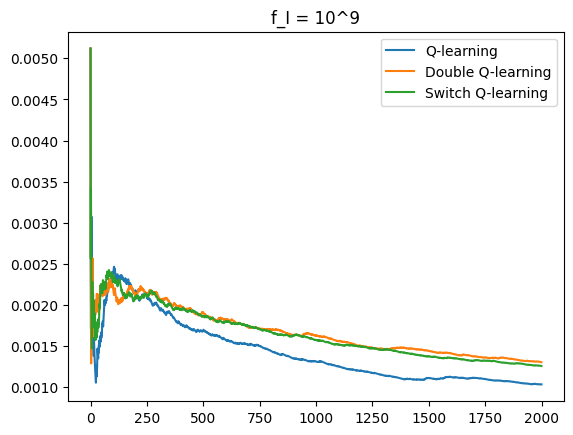

In [11]:

r_list_q,r_sum_list_q,r_sum_avg_list_q,local_actions_q = Server_Q_learning(N,n,mu,lamda,gamma)
r_list_dq,r_sum_list_dq,r_sum_avg_list_dq,local_actions_dq = Server_DoubleQ_learning(N,n,mu,lamda,gamma)
r_list,r_sum_list,r_sum_avg_list,local_actions,slist,Qa,Qb = Server_SwitchQ_learning(N,n,mu,lamda,gamma)
plt.plot(-r_sum_list_q)
plt.plot(-r_sum_list_dq)
plt.plot(-r_sum_list)


plt.title("f_I = 10^" + str(int(np.log10(f_I))) )
plt.legend(["Q-learning", "Double Q-learning","Switch Q-learning"])

In [65]:
r_avg_list_q = []
for i in range(len(r_list_q) - 100):
    r_avg_list_q.append(np.mean(r_list_q[i:i+100]))

r_avg_list_dq = []
for i in range(len(r_list_dq) - 100):
    r_avg_list_dq.append(np.mean(r_list_dq[i:i+100]))

r_avg_list = []
for i in range(len(r_list) - 100):
    r_avg_list.append(np.mean(r_list[i:i+100]))



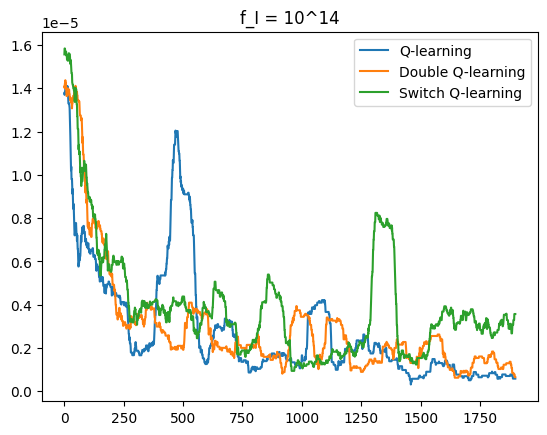

In [66]:
plt.plot(-np.array(r_avg_list_q))
plt.plot(-np.array(r_avg_list_dq))
plt.plot(-np.array(r_avg_list))

plt.title("f_I = 10^" + str(int(np.log10(f_I))) )
plt.legend(["Q-learning", "Double Q-learning","Switch Q-learning"], loc ="upper right")

In [20]:
def Server_WeightedDoubleQ_learning(N,n,mu,lamda,gamma,c):

    reward_list = []
    reward_sum_list = []
    reward_sum_avg_list = np.array([0]*N)
    runs = 1
    
    for ind in range(runs):
        reward_sum = 0
        count = 0
        Qa = np.zeros((n,n,2))
        Qb = np.zeros((n,n,2))
        freq = np.ones((n,n))
        freq_action = np.ones((n,n,2))
        (arrivals,departures) = arrival_and_departure_times(mu,lamda,N)
        local_pos = 0;cloud_pos = 0
        local_actions = np.array([False]*N)
        cloud_actions = np.array([False]*N)
        reward_list = []
        reward_sum_list = []
        for i in range(N):
            local_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (local_actions)).sum()
            cloud_pos = ((departures > arrivals[i]) & (arrivals < arrivals[i]) & (cloud_actions)).sum()
            eps = 1/np.sqrt(freq[local_pos,cloud_pos])
            action = np.random.choice([np.argmax(Qa[local_pos,cloud_pos] + Qb[local_pos,cloud_pos]),np.random.choice([0,1])],p = [1 - eps,eps])
            if local_pos == n:
                action = 1
            if cloud_pos == n:
                action = 0        
            if action == 0:
                local_actions[i] = 1
            if action == 1:
                cloud_actions[i] = 1
            (new_local_pos,new_cloud_pos,reward) = next_state(local_pos,cloud_pos,action)
            reward_sum = reward_sum + reward
            count = count + 1
            alpha = 1/np.power(freq_action[local_pos,cloud_pos, action],0.8)
            if np.random.choice([True,False]):
                action_max = np.argmax(Qa[new_local_pos,new_cloud_pos])
                action_min = np.argmin(Qa[new_local_pos,new_cloud_pos])
                diff = np.abs(Qb[local_pos,cloud_pos,action_max] - Qb[local_pos,cloud_pos,action_min])
                beta = diff/(diff + c)
                Qa[local_pos,cloud_pos,action] = Qa[local_pos,cloud_pos,action] + alpha*(reward + gamma*(beta*Qa[local_pos,cloud_pos,action_max] + (1-beta)*Qb[local_pos,cloud_pos,action_max]) - Qa[local_pos,cloud_pos,action])
            else:
                action_max = np.argmax(Qb[new_local_pos,new_cloud_pos])
                action_min = np.argmin(Qb[new_local_pos,new_cloud_pos])
                diff = np.abs(Qa[local_pos,cloud_pos,action_max] - Qa[local_pos,cloud_pos,action_min])
                beta = diff/(diff + c)
                Qb[local_pos,cloud_pos,action] = Qb[local_pos,cloud_pos,action] + alpha*(reward + gamma*(beta*Qb[local_pos,cloud_pos,action_max] + (1-beta)*Qa[local_pos,cloud_pos,action_max]) - Qb[local_pos,cloud_pos,action])
            freq[local_pos,cloud_pos] = freq[local_pos,cloud_pos] + 1
            freq_action[local_pos,cloud_pos,action] = freq_action[local_pos,cloud_pos,action] + 1     
            reward_list.append(reward)
            reward_sum_list.append(reward_sum/count)
        reward_sum_avg_list = reward_sum_avg_list + np.array(reward_sum_list)
    return reward_list,reward_sum_list,reward_sum_avg_list/runs,local_actions

In [21]:
r_list_wq,r_sum_list_wq,r_sum_avg_list_wq,local_actions_wq = Server_WeightedDoubleQ_learning(N,n,mu,lamda,gamma,10)

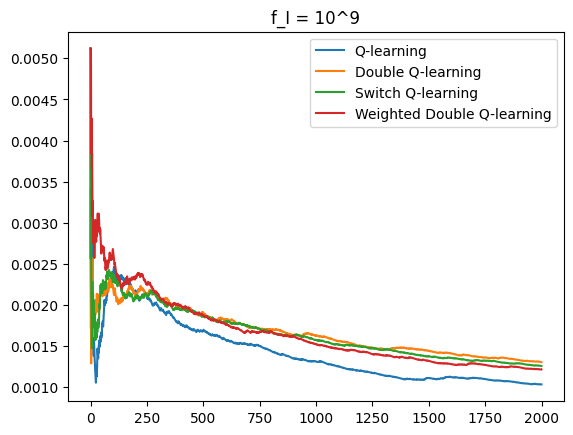

In [23]:
plt.plot(-r_sum_avg_list_q)
plt.plot(-r_sum_avg_list_dq)
plt.plot(-r_sum_avg_list)
plt.plot(-r_sum_avg_list_wq)

plt.title("f_I = 10^"+str(int(np.log10(f_I))))
plt.legend(["Q-learning", "Double Q-learning","Switch Q-learning","Weighted Double Q-learning"], loc ="upper right")